In [77]:
%matplotlib inline

In [78]:
import pylab

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get specific functions from some other python libraries
from math import floor, log
from scipy.stats import skew, kurtosis
from scipy.io import loadmat  
import scipy.fftpack
from tqdm import tqdm
import os
import re
import seaborn as sns
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [80]:
path = '/Users/fenilsuchak/Desktop/seer-py/Examples/Pat1Train'

In [81]:
sample_inter = loadmat(path+'/Pat1Train_100_0.mat')

In [82]:
# fig = plt.figure(figsize=(100,100))
# for i in range(16):
#     num = int(i+1)
#     ax = fig.add_subplot(16,1,num)
#     ax.plot(sample_inter['data'][:,i])
# #lets plot my brain wave
# np.random.seed(1)
# fig = plt.figure()
# ax_inter = fig.add_subplot(121)
# fft_inter = scipy.fftpack.fft(sample_inter['data'][:,0])
# fft_inter = [abs(elem) for elem in fft_inter][0:120000]
# fft_inter = np.expand_dims(fft_inter, axis = -1)
# fft_inter = fft_inter/(max(fft_inter))
# ax_inter.set_title("Interictal")
# ax_inter.plot(fft_inter) # for some reason this is symmetric.
# ########
# ax_pre = fig.add_subplot(122)
# fft_pre = scipy.fftpack.fft(sample_pre['data'][:,0])
# fft_pre = [abs(elem) for elem in fft_pre][0:120000]
# fft_pre = np.expand_dims(fft_pre, axis = -1)
# fft_pre = fft_pre/(max(fft_pre))
# ax_pre.set_title("Preictal")
# ax_pre.plot(fft_pre) # for some reason this is symmetric.
# plt.show()
# #lets plot my brain wave
# np.random.seed(1)
# fig = plt.figure()
# ax_inter = fig.add_subplot(121)
# fft_inter = scipy.fftpack.fft(sample_inter['data'][:,0][0:])
# fft_inter = [abs(elem) for elem in fft_inter][0:1600]
# fft_inter = np.expand_dims(fft_inter, axis = -1)
# fft_inter = fft_inter/(max(fft_inter))
# ax_inter.set_title("Interictal")
# ax_inter.plot(fft_inter) # for some reason this is symmetric.
# ########
# # ax_pre = fig.add_subplot(122)
# # fft_pre = scipy.fftpack.fft(sample_pre['data'][:,0])
# # fft_pre = [abs(elem) for elem in fft_pre][0:200]
# # fft_pre = np.expand_dims(fft_pre, axis = -1)
# # fft_pre = fft_pre/(max(fft_pre))
# # ax_pre.set_title("Preictal")
# # ax_pre.plot(fft_pre) # for some reason this is symmetric.
# plt.show()

In [83]:
#Frequency of interests
def defineEEGFreqs():
    
    '''
    EEG waveforms are divided into frequency groups. These groups seem to be related to mental activity.
    alpha waves = 8-13 Hz = Awake with eyes closed
    beta waves = 14-30 Hz = Awake and thinking, interacting, doing calculations, etc.
    gamma waves = 30-45 Hz = Might be related to conciousness and/or perception (particular 40 Hz)
    theta waves = 4-7 Hz = Light sleep
    delta waves < 3.5 Hz = Deep sleep

    There are other EEG features like sleep spindles and K-complexes, but I think for this analysis
    we are just looking to characterize the waveform based on these basic intervals.
    '''
    return (np.array([0.1, 4, 8, 14, 30, 45, 70, 180]))  # Frequency levels in Hz

In [84]:
train_list = os.listdir(path)
train_list = train_list[1:]

In [85]:
train_df = pd.DataFrame()

In [86]:
def get_amps(fft):
    gamma = np.mean(fft[:, 0:3], axis = 1)
    gamma = (gamma - np.mean(gamma))/np.std(gamma)
    theta = np.mean(fft[:, 4:7], axis = 1)
    theta = (theta - np.mean(theta))/np.std(theta)
    alpha = np.mean(fft[:,8:13], axis = 1)
    alpha = (alpha - np.mean(alpha))/np.std(alpha)
    beta = np.mean(fft[:,14:30] , axis = 1)
    beta = (beta - np.mean(beta))/np.std(beta)
    return list(gamma), list(theta), list(alpha), list(beta)  

In [87]:
#Dividing 10 minute segments into x seconds segments ie.
def divide_segment(x, segment, sampling_freq):
    '''Returns a list of  24000/(num_points) segments, each sub_segment has shape num_points*16'''
    div_list = []
    i = 0
    num_points = x*sampling_freq
    while(i*num_points<240000):
        div_list.append(segment[i*num_points:(i+1)*num_points,:])
        i+=1
    return div_list

In [ ]:
#Create FFT features for whole signal and extract apmplitudes of alpha, beta gamma delta. Average FFT in that range.
for i in tqdm(train_list):
    reg1 = r'.*?\_(.*)\..*'
    match = re.search(reg1, i)
    text = match.group(1)
    segment = text.split('_')[0]
    label = text.split('_')[1]
    temp = loadmat(path + '/' + i)['data']
    divided = divide_segment(100, temp, 400)
    for i,elem in enumerate(divided):
        #Extracting FFT
        fft = abs(np.fft.fft(elem, axis = 0))
        fft = fft.T
        gamma, theta, alpha, beta = get_amps(fft)
        gamma.extend(theta)
        gamma.extend(alpha)
        gamma.extend(beta) 
        elem = ['segment_no' + segment + '_sub_{}'.format(i)] + gamma + [label]
        train_df = train_df.append(pd.DataFrame(elem).T)

In [89]:
train_df.reset_index(inplace = True)
train_df.drop('index', axis = 1, inplace=True)

In [90]:
d = {}
for i in range(66):
    if i == 0:
        d[i] = 'segment_number'
    elif i > 0 and i < 65:
        if i < 17:
            d[i] = 'gamma_electrode_{}'.format(i)
        elif i >= 17 and i < 33:
            d[i] = 'theta_electrode_{}'.format(i-16)
        elif i >= 33 and i < 49:
            d[i] = 'alpha_electrode_{}'.format(i-32)
        elif i >= 49 and i < 65:
            d[i] = 'beta_electrode_{}'.format(i-48)
    elif i == 65:
        d[i] = 'Class'

In [91]:
for col in train_df.columns[1:-1].values:
    train_df[col] = train_df[col].astype(np.float64)

In [92]:
train_df = train_df.rename(columns= d)

In [ ]:
#Visualizing
sns.distplot(train_df[train_df['Class'] == 0]['beta_electrode_1'], color = 'green' , hist = False, rug = True)
sns.distplot(train_df[train_df['Class'] == 1]['beta_electrode_1'], color = 'blue',  hist = False, rug = True)
plt.show()

In [93]:
#FFT done.
#Next feature.

<Figure size 1440x1440 with 0 Axes>

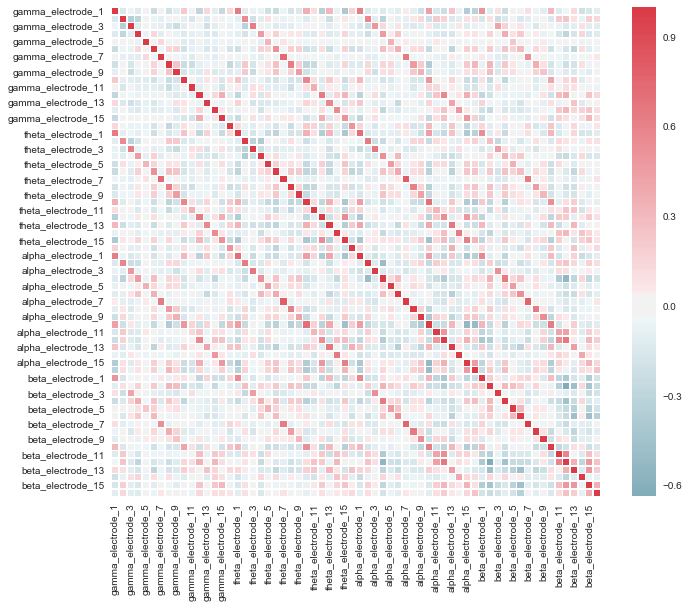

In [94]:
#The electrode has high alpha,beta,gamma correlation.
plt.figure(figsize=(20,20))
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=train_df,
                 columns=train_df.columns.values[1:-1])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5)

In [95]:
temporal_df = pd.DataFrame()

In [ ]:
#Simple Temporal Domain Features Mean, Std, Kurtosis, Skewness
for i in tqdm(train_list):
    reg1 = r'.*?\_(.*)\..*'
    match = re.search(reg1, i)
    text = match.group(1)
    segment = text.split('_')[0]
    label = text.split('_')[1]
    temp = loadmat(path + '/' + i)['data']
    divided = divide_segment(100, temp, 400)
    for i,elem in enumerate(divided):
        mean = list(np.mean(elem,axis = 0))
        std = list(np.std(elem, axis = 0))
        kur = list(scipy.stats.kurtosis(elem,axis = 0))
        skew = list(scipy.stats.skew(elem,axis = 0))
        mean.extend(std)
        mean.extend(kur)
        mean.extend(skew)
        temporal_df = temporal_df.append(pd.DataFrame(mean).T)

In [97]:
temporal_df.reset_index(inplace = True)
temporal_df.drop('index', axis = 1, inplace=True)

In [98]:
#Combining train_df (frequency_domain) and tremporal_df(time_domain) features.

In [99]:
columns_dict = {}
for i in range(32):
    if i < 16:
        columns_dict[i] = 'mean_{}'.format(i)
    else:
        columns_dict[i] = 'std_{}'.format(i%16)

In [100]:
temporal_df.rename(columns = columns_dict, inplace = True)

In [101]:
temporal_df.head()

,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,54,55,56,57,58,59,60,61,62,63
0,-0.099442,-1.145510,0.630902,0.091244,-0.099143,0.100101,-0.421213,-0.553829,-0.038585,-0.293007,...,-0.366200,-0.600031,-0.380567,-0.172601,0.699400,-0.648069,-0.436229,-0.969009,0.385553,-0.020993
1,-0.021167,0.560605,-0.021626,0.847605,0.051308,-0.516375,0.178468,0.299417,0.005308,-0.068734,...,-0.343801,-0.268768,-0.304608,-0.353180,-0.141281,0.103767,-0.377163,-1.151825,0.082597,0.210804
2,-0.047030,0.192126,-0.455849,0.532927,0.342283,0.168918,-0.125105,-0.565387,-0.181533,-0.267476,...,-0.576939,-0.134434,-0.324134,-0.069146,-0.237116,0.139479,-0.474718,-0.649286,-0.144267,0.053292
3,0.190443,-0.103165,0.399263,-1.030450,0.305684,0.088290,0.193954,-0.083930,-0.608900,-0.361524,...,-0.532948,-0.416339,-0.322152,-0.010532,-0.196698,0.165413,-0.024634,-0.867680,-0.287022,-0.375244
4,-0.164411,0.795222,-0.375389,1.724084,-0.248397,-0.167391,-0.398846,-0.474541,0.492850,-0.033530,...,-0.322996,-0.490777,-0.444989,-0.432916,-0.089885,0.098327,0.178342,-0.740880,0.204076,-0.006649


In [102]:
assert train_df.shape[0] == temporal_df.shape[0]

In [103]:
train_new_df = pd.concat([train_df,temporal_df], axis = 1)

In [31]:
# For dropping nan values. Will be done after other features.
# train_df_empty_dropped = train_new_df.loc[np.sum(pd.isnull(train_new_df), axis = 1) != 64, :] 

### Idea for cross correlation features picked from
### EEG-based neonatal seizure detection with Support Vector Machines

In [ ]:
#Simple correlation feature along temporal domain.
cross_df = pd.DataFrame()
for i in tqdm(train_list):
    reg1 = r'.*?\_(.*)\..*'
    match = re.search(reg1, i)
    text = match.group(1)
    segment = text.split('_')[0]
    label = text.split('_')[1]
    temp = loadmat(path + '/' + i)['data']
    divided = divide_segment(100, temp, 400)
    for i,elem in enumerate(divided):
        temp = pd.DataFrame(elem)
        corr_matrix = np.array(temp.corr())
        mask = np.tril_indices(16, k = -1)
        final_temp = corr_matrix[mask]
        final_temp = final_temp.flatten()
        cross_df = cross_df.append(pd.DataFrame(final_temp).T)

In [73]:
cross_df.reset_index(inplace = True)
cross_df.drop('index', axis = 1, inplace=True)

In [74]:
#Feature names necessary? Because cant identify .Will see later. 
#Not so robust naming
col_names = {}
for i in range(120):
    col_names[i] = 'correl_{}'.format(i)
    
    

In [75]:
cross_df.rename(columns= col_names, inplace = True)

In [76]:
cross_df.head()

,correl_0,correl_1,correl_2,correl_3,correl_4,correl_5,correl_6,correl_7,correl_8,correl_9,...,correl_110,correl_111,correl_112,correl_113,correl_114,correl_115,correl_116,correl_117,correl_118,correl_119
0,0.438160,0.201767,0.377982,-0.083567,-0.123836,0.002184,-0.031213,-0.048455,-0.008645,-0.079360,...,-0.192952,0.092996,0.299853,-0.290792,-0.195358,-0.285207,0.482820,-0.160051,-0.171980,0.019669
1,0.326510,0.244387,0.253567,-0.040660,-0.018000,0.027344,-0.110035,-0.122731,-0.129883,-0.033654,...,-0.176434,0.089466,0.236831,-0.277466,-0.286119,-0.165525,0.409367,-0.160118,-0.135744,0.123751
2,0.417895,0.252831,0.308845,-0.077892,-0.078998,0.056543,-0.071813,-0.065726,-0.040977,-0.062931,...,-0.184661,0.188879,0.344975,-0.333263,-0.303298,-0.211855,0.434442,-0.207492,-0.224232,0.186723
3,0.421376,0.246873,0.280775,-0.012455,-0.048584,0.022168,-0.092110,-0.032281,-0.061392,-0.043142,...,-0.278045,0.189938,0.351555,-0.212478,-0.273220,-0.120409,0.386610,-0.160616,-0.136392,0.151306
4,0.440086,0.215838,0.359105,-0.029470,-0.050695,0.037527,0.023957,-0.067701,-0.107020,-0.027230,...,-0.241447,0.198233,0.355699,-0.295121,-0.245932,-0.138293,0.313939,-0.145916,-0.215411,0.150109


In [106]:
train_new_df = pd.concat([train_df,cross_df], axis = 1)

In [111]:
train_new_df.head()

,segment_number,gamma_electrode_1,gamma_electrode_2,gamma_electrode_3,gamma_electrode_4,gamma_electrode_5,gamma_electrode_6,gamma_electrode_7,gamma_electrode_8,gamma_electrode_9,...,correl_110,correl_111,correl_112,correl_113,correl_114,correl_115,correl_116,correl_117,correl_118,correl_119
0,segment_no1009_sub_0,-0.829771,1.257513,1.034657,1.139142,-0.941668,-0.809197,-0.469328,-0.098035,-0.095909,...,-0.192952,0.092996,0.299853,-0.290792,-0.195358,-0.285207,0.482820,-0.160051,-0.171980,0.019669
1,segment_no1009_sub_1,-1.102607,0.701587,-0.657912,2.153541,-0.673490,-0.180865,-0.802661,0.196471,-0.957170,...,-0.176434,0.089466,0.236831,-0.277466,-0.286119,-0.165525,0.409367,-0.160118,-0.135744,0.123751
2,segment_no1009_sub_2,-0.659935,0.147199,0.146276,2.701836,-0.657334,-0.917035,-0.800684,-0.210275,-0.590139,...,-0.184661,0.188879,0.344975,-0.333263,-0.303298,-0.211855,0.434442,-0.207492,-0.224232,0.186723
3,segment_no1009_sub_3,-0.656700,0.287582,-0.514431,1.875256,-0.333928,-1.061494,-0.299572,-0.781477,-0.035067,...,-0.278045,0.189938,0.351555,-0.212478,-0.273220,-0.120409,0.386610,-0.160616,-0.136392,0.151306
4,segment_no1009_sub_4,-0.729542,1.080733,0.280571,3.167767,-0.580894,-0.214848,-0.481397,0.089487,0.334535,...,-0.241447,0.198233,0.355699,-0.295121,-0.245932,-0.138293,0.313939,-0.145916,-0.215411,0.150109
